# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame input | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,356] | 0.1|
 


<div style="overflow-x: auto;">

## PSPI from (Action Units)
Pain expression is widely characterized by the activation of a small set of facial muscles and coded by a set of
corresponding actions units (AUs): 
| Action units  | Meaning              | Range   |
|----------------|----------------------|---------|
| AU 4          | brow lowering        | 0 to 5  |
| AU 6 and AU 7 | orbital tightening   | 0 to 5  |
| AU 9 and AU 10| levator labii raise  | 0 to 5  |
| AU 43         | eye closure          | 0 or 1  |
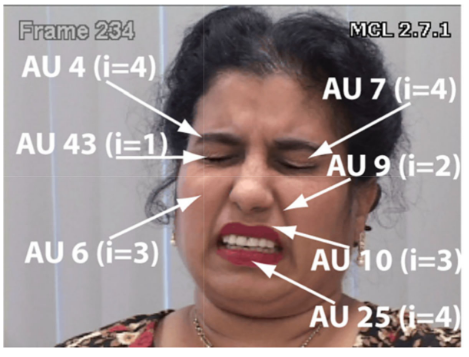

STEPS for preprocessing:
1) Align faces by fixing the inter-ocular distance.
2) Compute mean facial shape by averaging all of the landmark points in the roughly aligned faces.
3) Warp each face in the database to the average face using piece-wise linear warping,where the facial pieces are formed using Delaunay triangulation.
4) Crop out the normalized faces by forming a mask with the convex hull of the landmark points resulting in 224×224 images

# COde

In [ ]:
with open("k710_labels/k710_label_map.txt",'r') as f:
  label_map = f.readlines()
  label_map = [x.strip() for x in label_map]
  print(len(label_map))
  print(label_map)
label_map = np.array(label_map)

In [ ]:
label_prediction_dict = {}
np_labels = np.array(list_labels)
class_results = np.array(list_results)
for label in np.unique(np_labels):
  # print(f"Label: {label}, Prediction: {prediction}")
  mask = (np_labels == label)
  masked_results  = class_results[mask]
  label_prediction_dict[label] = masked_results
prediction_to_label = {k:(list(zip(label_map[np.unique(v)],np.unique(v,return_counts=True)[1]))) for k,v in label_prediction_dict.items()}
for k,v in prediction_to_label.items():
  print(f'{k}: {v}')
accuracy_dict = {}
for label in label_prediction_dict:
  count_prediction = np.bincount(label_prediction_dict[label])
  accuracy_dict[label] = count_prediction.max().item() / count_prediction.sum().item()
print('\nAccuracy dict:')
for k,v in accuracy_dict.items():
  print(f'  {k}: {v}')
print('Mean accuracy:', np.mean(list(accuracy_dict.values())))


In [ ]:
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import custom.tools as tools

feature_frontalized_path = "partA/video/features/samples_16_frontalized"
feature_frontalized = tools.load_dict_data(feature_frontalized_path)
feature_frontalized_new_path = "partA/video/features/samples_16_frontalized_new"
feature_frontalized_new = tools.load_dict_data(feature_frontalized_new_path)


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
list_unique_sample_id = np.unique(feature_frontalized['list_sample_id'])
list_cosine_similarity = []
for sample_id in list_unique_sample_id:
  mask = feature_frontalized['list_sample_id'] == sample_id
  mask_new = feature_frontalized_new['list_sample_id'] == sample_id
  feature_old = feature_frontalized['features'][mask].reshape(feature_frontalized['features'][mask].shape[0],-1)
  feature_new = feature_frontalized_new['features'][mask_new].reshape(feature_frontalized_new['features'][mask_new].shape[0],-1)
  cosine_sim = cosine_similarity(feature_old,feature_new)
  list_cosine_similarity.append(cosine_sim.min())
  # print(f"Sample id: {sample_id}, cosine similarity: {cosine_sim.mean()}")
list_cosine_similarity = np.array(list_cosine_similarity)

In [ ]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('jepa')
from jepa.src.models.attentive_pooler import AttentiveClassifier
att_classifier = AttentiveClassifier(num_classes=5,pos_enc=True)
num_params = sum(p.numel() for p in att_classifier.parameters())
print(num_params)
x_sample = torch.randn(2,3,768)
att_classifier(x_sample)
x_sample = torch.randn(2,5,768)
att_classifier(x_sample)

# Dictionary to store activations from the hook.
activations = {}

def activation_hook(module, input, output):
    # Save the output (detach to avoid keeping the computation graph)
    activations['attn_out'] = output.detach()

# Register the forward hook on the cross_attention_block.
# If you want to monitor the final output of the cross-attention block, register it on that module.
hook_handle = att_classifier.pooler.cross_attention_block.register_forward_hook(activation_hook)

# Run a forward pass with your input (make sure your input x is of shape [B, T, C]).
dummy_input = torch.randn(8, 196, 768)  # Example: batch size 8, sequence length 196, embedding size 768.
_ = att_classifier(dummy_input)

# Now extract the activations.
attn_activations = activations.get('attn_out')
if attn_activations is None:
    print("No activations captured. Check your hook registration.")
else:
    print("Activation shape:", attn_activations.shape)
    # Flatten and convert to CPU numpy array for plotting.
    act_flat = attn_activations.view(-1).cpu().numpy()
    plt.figure(figsize=(8, 4))
    plt.hist(act_flat, bins=50, color='skyblue', edgecolor='black')
    plt.title("Activation Distribution at Cross-Attention Block")
    plt.xlabel("Activation value")
    plt.ylabel("Frequency")
    plt.show()

# Remove the hook to avoid unwanted effects in further passes.
hook_handle.remove()


In [ ]:
import custom.head as head
attentive_head = head.AttentiveClassifierJEPA(num_classes=5,num_heads=8,embed_dim=768,
                                              mlp_ratio=1,depth=3,
                                              cross_block_after_transformers=False)
# count params in attentive head
num_params = sum(p.numel() for p in attentive_head.parameters())
print(num_params)
name_params = [name for name, param in attentive_head.named_parameters()]

In [ ]:
gpu_for_num_params = num_params * 4 / (1024**3)  # Convert to GB
print(f"Number of parameters in GB: {gpu_for_num_params:.2f} GB")

In [ ]:
l1_norm = sum(param.abs().sum() for param in attentive_head.parameters() if param.requires_grad and not 'bias' in name_params)
l1_norm_tot = sum(param.abs().sum() for param in attentive_head.parameters() if param.requires_grad)

In [ ]:
import pandas as pd

csv_path = "partA/starting_point/samples_exc_no_detection.csv"
df = pd.read_csv(csv_path,sep='\t')
filter_ = {
  'class_id':[0,3]
}
new_df = df[df['class_id'].isin(filter_['class_id'])]
# set class id 4 to 1
new_df['class_id'] = new_df['class_id'].replace(filter_['class_id'][1],1)
new_df.to_csv(f"partA/starting_point/samples_exc_no_detection_{filter_['class_id'][0]}_{filter_['class_id'][1]}.csv",index=False,sep='\t')

In [ ]:
import custom.tools as tools
dict_data = tools.load_dict_data("/media/villi/TOSHIBA EXT/samples_16_frontalized_new_giant_hflip")
dict_data['list_sample_id']

In [ ]:
import pandas as pd
import custom.helper as helper
stoic = helper.stoic_subjects
csv_path = "partA/starting_point/samples_exc_no_detection.csv"
df = pd.read_csv(csv_path,sep='\t')
key = 'subject_id'
all_subjects = df[key].unique()
no_stoic = [s for s in all_subjects if s not in stoic]
filter_ = {
  key: no_stoic
}
new_df = df[df[key].isin(filter_[key])]
new_df.to_csv(f"partA/starting_point/samples_exc_no_detection_no_stoic.csv",index=False,sep='\t')

In [ ]:
from custom.faceExtractor import FaceExtractor
import cv2
import pickle
face_extractor = FaceExtractor(visionRunningMode='image')
image_path = "new_image/img.png"

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ref_landmarks_path = "partA/video/mean_face_landmarks_per_subject/all_subjects_mean_landmarks.pkl"
with open(ref_landmarks_path, 'rb') as f:
  ref_landmarks = pickle.load(f)
dict_result = face_extractor.frontalize_img(frame=img,ref_landmarks=ref_landmarks['mean_facial_landmarks'])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dict_result['frontalized_img'])
# dict_result['frontalized_img']

In [ ]:
import pickle
pkl_path="history_run_1_96404_ATTENTIVE_JEPA_villi-Inspiron-16-Plus-7620_1743712318/1743712318371_VIDEOMAE_v2_B_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)
data['results'].keys()

In [ ]:
df_path_2 = "/media/villi/TOSHIBA EXT/test_video/test_Apr_04/pre_test_drop_posEmb/_summary/plot_run_details/summary.csv"
df_2 = pd.read_csv(df_path_2)
input_path = "/media/villi/TOSHIBA EXT/test_video/test_Apr_04/test_drop_posEmb_smooth/_summary/plot_run_details/summary.csv"
df = pd.read_csv(input_path)
concatenate_df = pd.concat([df, df_2], axis=0)
concatenate_df.to_csv("summary_concat.csv",index=False)

In [ ]:
import numpy as np
import pandas as pd

def process_summary_csv(
  df,
  output_csv_path="df_filtered.csv",
  filter_vals={'reg_lambda_L1': 0.00001, 'reg_lambda_L2': 0},
  fixed_col=['label_smooth'],
  hyper_cols=['ATTENTIVE_JEPA.dropout', 'ATTENTIVE_JEPA.attn_dropout', 'ATTENTIVE_JEPA.residual_dropout','ATTENTIVE_JEPA.pos_enc'],
  metric=['total_mean_val_accuracy_best_ep'],
  additional_cols=['total_mean_test_accuracy_best_ep']
):
  """
  Processes the summary CSV file by filtering rows based on fixed parameter values,
  selecting specific columns, grouping by unique hyperparameter values, and calculating
  the difference in the specified metric between the best and worst cases for each group.

  Parameters:
    input_csv_path (str): Path to the input CSV file.
    output_csv_path (str): Path to save the output CSV file. Defaults to "df_filtered.csv".
    fixed_vals (dict): Dictionary of column names and their fixed values for filtering.
    tmp_cols (list): List of temporary column names to include.
    hyper_cols (list): List of hyperparameter column names to group by.
    metric (list): List containing the metric column name used for determining best and worst rows.
    additional_cols (list): List of additional columns to include from the CSV.

  Returns:
    pd.DataFrame: A DataFrame with the filtered, processed, and sorted results.
  """
  cols_to_show = additional_cols[:1] + hyper_cols + fixed_col + additional_cols[1:] + metric

  df_filtered = df.copy()
  for col, val in filter_vals.items():
    df_filtered = df_filtered[df_filtered[col] == val]

  df_filtered = df_filtered[cols_to_show]
  hyper_values = df_filtered[hyper_cols].values
  
  unique_hyper_configs = np.unique(hyper_values.astype(np.float64), axis=0)

  processed_rows = []
  new_columns = cols_to_show + ['diff_validation']
  for i,col in enumerate(new_columns):
    split_cols = col.split('.')
    new_columns[i] = split_cols[-1]
  for config in unique_hyper_configs:
    mask = np.all(hyper_values == config, axis=1)
    subset = df_filtered.loc[mask]

    best_row = subset.loc[subset[metric].idxmax()]
    worst_row = subset.loc[subset[metric].idxmin()]
    metric_diff = np.round(best_row[metric].values - worst_row[metric].values, 4)

    new_row = best_row.copy()
    new_row['diff_validation'] = metric_diff[0]
    processed_rows.append(new_row.values.reshape(-1))

  df_result = pd.DataFrame(processed_rows, columns=new_columns)
  df_result.sort_values(by=metric, ascending=False, inplace=True)
  df_result.to_csv(output_csv_path, index=False)

  return df_result

# Example usage
if __name__ == "__main__":
  input_csv_path="/media/villi/TOSHIBA EXT/test_video/test_Apr_18/pre_LOSO/_summary/plot_run_details/summary.csv"
  # filter_vals={'reg_lambda_L1': 0.00001, 'reg_lambda_L2': 0}
  df = pd.read_csv(input_csv_path)
  filter_vals={}
  fixed_col=['ATTENTIVE_JEPA.attn_dropout']
  hyper_cols=['label_smooth', 'ATTENTIVE_JEPA.dropout', 'ATTENTIVE_JEPA.residual_dropout','ATTENTIVE_JEPA.pos_enc','reg_lambda_L1','reg_lambda_L2']
  metric=['total_mean_val_accuracy_best_ep']
  additional_cols=['total_mean_test_accuracy_best_ep']
  df_new = process_summary_csv(df=df,
                               additional_cols=additional_cols,
                              filter_vals=filter_vals,
                              fixed_col=fixed_col,
                              hyper_cols=hyper_cols,
                              metric=metric)

# df_new
  grouped = df.groupby(hyper_cols)
  grouped_dict = {group: df.copy() for group, df in grouped}

In [ ]:
import custom.tools as tools
video_path = "z_sampling_video/071309_w_21-PA4-043_inside_2_stride_32_fps_12.mp4"
grid_size = (14,14)
tools.split_video_with_chunks(
  video_path=video_path,
  chunk_size=16,
  new_fps=8,
  output_folder="z_debug_grid",
  separator_duration=8 
)

In [ ]:
import custom.dataset as dataset
import custom.helper as helper

stride_inside_window = 2
clip_length = 16
color_jitter = False
flip_horizontal = False
rotation = False
ds = dataset.customDataset(
  path_dataset="partA/video/video_frontalized_new",
  path_labels="partA/starting_point/samples_exc_no_detection.csv",
  sample_frame_strategy=helper.SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW,
  clip_length=clip_length,
  stride_inside_window=stride_inside_window,
  stride_window=(clip_length)*stride_inside_window,
  saving_folder_path_extracted_video="z_sampling_video",
  color_jitter=color_jitter,
  flip_horizontal=flip_horizontal,
  rotation=rotation,
)
augm = 'hflip' if flip_horizontal else ''+ 'jitter' if color_jitter else '' + 'rotation' if rotation else ''
ds.generate_video(idx=91,fps_out=12,output_folder=f"z_debug_video_{augm}")


In [ ]:
print(f'Size: {(4*8*14*14*768)*2*8700/1024**3} GB')

In [ ]:
import safetensors
import safetensors.torch
import torch
import custom.tools as tools

tools.convert_dict_to_safetensors(dict_folder_path="partA/video/features/samples_16_frontalized_new_rotate")

In [ ]:
tools.convert_dict_to_safetensors(dict_folder_path="partA/video/features/samples_16_frontalized_new")

In [ ]:
import safetensors.torch
import torch
import custom.helper as helper
import custom.tools as tools
list_path = [
             "partA/video/features/samples_16_frontalized_new.safetensors",
             "partA/video/features/samples_16_frontalized_new_hflip.safetensors",
             "partA/video/features/samples_16_frontalized_new_rotation.safetensors",
             ]
for path in list_path:
  dict_data = tools.load_dict_data(path)
  print(path)
  if 'list_sample_id' in dict_data:
    # dict_data['list_sample_id'] = dict_data['list_sample_id'] + helper.get_shift_for_sample_id(path)
    print(f"  {torch.max(dict_data['list_sample_id'])}")
    print(f"  {torch.min(dict_data['list_sample_id'])}")
  # safetensors.torch.save_file(dict_data, path)

In [ ]:
import safetensors.torch
import torch
import custom.helper as helper
dict_data = safetensors.torch.load_file("partA/video/features/samples_16_frontalized_new_hflip.safetensors")
for k,v in dict_data.items():
  print(f'{k}: {v.shape}')
  print(f'dtype: {v.dtype}')
  if k == 'list_sample_id':
    dict_data[k]=dict_data[k].to(torch.int32)
    dict_data[k] = dict_data[k] + helper.get_shift_for_sample_id('hflip') 
    print(torch.min(dict_data[k]).item())
    print(torch.max(dict_data[k]).item())
safetensors.torch.save_file(dict_data,"partA/video/features/samples_16_frontalized_new_rotation.safetensors")

In [ ]:
import custom.tools as tools
import time
tools.test_speed_safetensors_vs_standard(path_1="partA/video/features/samples_16_frontalized_new",
                                        path_2="partA/video/features/samples_16_frontalized_new.safetensors")

In [ ]:
import pickle
import optuna
pkl_path = "study_test"
with open(pkl_path, 'rb') as f:
  study = pickle.load(f)
study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

In [ ]:
import joblib
import optuna
from optuna.storages import RDBStorage

# 2. Create a new SQLite storage and study record
storage = RDBStorage(url="sqlite:///study.db")
study_id = storage.create_new_study(study_name="restored_study",directions=["MAXIMIZE"])

# 3. Replay all existing trials into the DB
for trial in study.get_trials(deepcopy=False):
    storage.create_new_trial(study_id=study_id, template_trial=trial)

# 4. (Optional) Load it back as an Optuna Study
restored = optuna.load_study(study_name="restored_study", storage=storage)


In [ ]:
import custom.helper as helper
import custom.dataset as dataset
from custom.dataset import customDataset
path_dataset = "partA/video/video_frontalized_new"
path_labels = "partA/starting_point/samples_exc_no_detection.csv"
sample_frame_strategy = helper.SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW
clip_length = 16
h_flip = False
rotation = True
color_jitter = True
preprocess_align = False
preprocess_frontalize = False
stride_inside_window = 2
stride_window = clip_length*stride_inside_window
preprocess_crop_detection = False

custom_ds = customDataset(path_dataset=path_dataset,
              path_labels=path_labels,
              sample_frame_strategy=sample_frame_strategy,
              stride_window=stride_window,
              clip_length=clip_length,
              flip_horizontal=h_flip,
              color_jitter=color_jitter,
              rotation=rotation,
              preprocess_align=preprocess_align,
              preprocess_frontalize=preprocess_frontalize,
              stride_inside_window=stride_inside_window,
              preprocess_crop_detection=preprocess_crop_detection,
              saving_folder_path_extracted_video=None)

custom_ds.generate_video(idx=93,output_folder="z_video")

In [ ]:
import pandas as pd
import numpy as np  
path_csv_1 = "partA/starting_point/samples.csv"
path_csv_2 = "partA/starting_point/samples_exc_no_detection.csv"

df_1 = pd.read_csv(path_csv_1,sep='\t')
df_2 = pd.read_csv(path_csv_2,sep='\t')

list_sample_id_1 = df_1['sample_id'].to_list()
list_sample_id_2 = df_2['sample_id'].to_list()
mask_1 = df_1['sample_id'].isin(list_sample_id_2)
len_1 = len(list_sample_id_1)
len_2 = len(list_sample_id_2)
print(f"Length of df_1: {len_1}")
print(f"Length of df_2: {len_2}")
len_1-len_2

In [ ]:
excluded_df = df_1[~mask_1]
pd.DataFrame.to_csv(excluded_df,"partA/starting_point/miss_detection.csv",index=False,sep='\t')
# give me the count per class_id and subject_id
print(excluded_df['class_id'].value_counts())
print(excluded_df['subject_id'].value_counts())

In [ ]:
list_subjects_1 = df_1['subject_id'].to_list()
list_subjects_2 = df_2['subject_id'].to_list()
unique_list_subjects_1,count_1 = np.unique(list_subjects_1,return_counts=True)
unique_list_subjects_2,count_2 = np.unique(list_subjects_2,return_counts=True)
print(f"Length of unique subjects in df_1: {len(unique_list_subjects_1)}")
print(f"Length of unique subjects in df_2: {len(unique_list_subjects_2)}")
diff = count_1 - count_2
(diff>0).sum()


In [ ]:
import custom.tools as tools
import pickle

pkl_path = "/media/villi/TOSHIBA EXT/test_video/test_May_09/ATTENTIVE_featshape_[2,2,2]_classification/augmentation/jitter/history_run_16_giant_2_2_2_jitter_1119231_ATTENTIVE_JEPA_targaryen_1746567968/1746629067854_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)

for k,v in data['results']['k0_cross_val_sub_0']['test'].items():
  print(f'{k}')
best_epoch = data['results']['k0_cross_val_sub_0']['train_val']['best_model_idx']
best_train_conf_matrix = data['results']['k0_cross_val_sub_0']['train_val']['train_confusion_matricies'][f'{best_epoch}']
best_val_conf_matrix = data['results']['k0_cross_val_sub_0']['train_val']['val_confusion_matricies'][f'{best_epoch}']
best_test_conf_matrix = data['results']['k0_cross_val_sub_0']['test']['test_confusion_matrix']

dict_accurcy_train = tools.evaluate_classification_from_confusion_matrix(best_train_conf_matrix,list_real_classes=data['results']['k0_cross_val_sub_0']['train_val']['train_unique_y'])
dict_accurcy_val = tools.evaluate_classification_from_confusion_matrix(best_val_conf_matrix,list_real_classes=data['results']['k0_cross_val_sub_0']['train_val']['val_unique_y'])
dict_accurcy_test = tools.evaluate_classification_from_confusion_matrix(best_test_conf_matrix,list_real_classes=data['results']['k0_cross_val_sub_0']['test']['test_unique_y'])
print(f"Accuracy at best epoch {best_epoch}: ")
print(f"  Train accuracy best epoch: {dict_accurcy_train['accuracy']}")
print(f"  Val accuracy best epoch  : {dict_accurcy_val['accuracy']}")
print(f"  Test accuracy best epoch : {dict_accurcy_test['accuracy']}")

In [ ]:
import torch

tmp = best_train_conf_matrix.compute().clone()[:5,:5]
print(tmp)
tools.evaluate_classification_from_confusion_matrix(tmp,list_real_classes=[0,1,2,3,4])

In [ ]:
tot_train = 796+239+349+679
tot_val = 326+13+212+128
tot_test = 320+38+255+103
print(f'Train acc {(826+775)/tot_train}')
print(f'Val acc {(306+176)/tot_val}')
print(f'Test acc {(313+111)/tot_test}')

In [ ]:
import custom.tools as tools
import pickle
import custom.faceExtractor as faceExtractor
import cv2
face_extractor = faceExtractor.FaceExtractor()
path_video_input = "/media/villi/TOSHIBA EXT/orig_video/video/video/112310_m_20/112310_m_20-PA2-020.mp4"
ref_landmarks_path = "partA/video/mean_face_landmarks_per_subject/all_subjects_mean_landmarks.pkl"
with open(ref_landmarks_path, 'rb') as f:
  ref_landmarks = pickle.load(f)
align_before_front = False
# frame = cv2.imread("z_debug_frontalization/test_frontal.png")
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# img =face_extractor.frontalize_img(frame=frame,
#                               ref_landmarks=ref_landmarks['mean_facial_landmarks'],
#                               align=False,)
dict_res=face_extractor.frontalized_video(video_path=path_video_input,
                                          ref_landmarks=ref_landmarks['mean_facial_landmarks'],
                                          align_before_front=align_before_front,
                                          interpolate_multiple=16)

In [ ]:
import custom.tools as tools
list_frames = dict_res['list_frontalized_frame']
tools.generate_video_from_list_frame(list_frame=list_frames,
                                     path_video_output=f'z_video/{path_video_input.split("/")[-1].split(".")[0]}_{align_before_front}.mp4')

In [ ]:
import os
import pandas as pd
import shutil
import tqdm
root_folder_video = "z_miss_detection_video"
list_video = []
df = pd.read_csv("partA/starting_point/miss_detection.csv",sep='\t')
list_df_sample_name = df['sample_name'].to_list()
for root, dirs, files in os.walk(root_folder_video):
  for file in files:
    if file.endswith(".mp4") and file[:-4] in list_df_sample_name:
      list_video.append(os.path.join(root,file))
print(f"Number of videos: {len(list_video)}")

# video_folder = "z_miss_detection_video"
# for video in tqdm.tqdm(list_video,desc="Copying videos"):
#   shutil.copy(video,video_folder)
# print(f"Video copied to {video_folder}")

In [ ]:
import custom.faceExtractor as faceExtractor
import pickle
import custom.tools as tools
import tqdm

face_extractor = faceExtractor.FaceExtractor(min_face_detection_confidence=0.5,
                                             min_tracking_confidence=0.5,
                                             min_face_presence_confidence=0.5)
ref_landmarks_path = "partA/video/mean_face_landmarks_per_subject/all_subjects_mean_landmarks.pkl"
with open(ref_landmarks_path, 'rb') as f:
  ref_landmarks = pickle.load(f)
for video_path in tqdm.tqdm(list_video,desc="Frontalizing video..."):
  video_name = video_path.split("/")[-1].split(".")[0]
  print(f"Processing video: {video_name}")
  dict_res=face_extractor.frontalized_video(video_path=video_path,
                                            ref_landmarks=ref_landmarks['mean_facial_landmarks'],
                                            align_before_front=False,
                                            interpolation_mod_chunk=None,
                                            )
  list_frames = dict_res['list_frontalized_frame']
  print(f'Len list frames {len(list_frames)}')
  tools.generate_video_from_list_frame(list_frame=list_frames,
                                       path_video_output=f'z_miss_detection_video/frontalized_mirror_{video_name}.mp4')


In [ ]:
import numpy as np
feat_np_path = "/media/villi/TOSHIBA EXT/th14_mae_g_16_4/video_test_0000004.npy"
feat_np = np.load(feat_np_path)
print(feat_np.shape)

In [ ]:
import pickle
path_pkl = "/media/villi/TOSHIBA EXT/test_video/test_May_23/interpol_cdw_ce/history_run_samples_interpola_8_1_1_cdw_ce_1660907_ATTENTIVE_JEPA_harlock_1747558119/1747607929294_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(path_pkl, 'rb') as f:
  data = pickle.load(f)



In [ ]:
data['config']['criterion'].get_params()

In [ ]:
import custom.tools as tools
feat = "partA/video/features/samples_16_frontalized_new.safetensors"
dict_data = tools.load_dict_data(feat)
print(dict_data['features'].shape)

In [ ]:
import optuna
import pandas as pd
import os

study_path = "/media/villi/TOSHIBA EXT/test_video/test_May_23/interpol_cdw_ce/history_run_samples_interpola_8_1_1_cdw_ce_1660907_ATTENTIVE_JEPA_harlock_1747558119/ATTENTIVE_JEPA_1747558119.db"
study_name = os.path.basename(study_path).split(".")[0]
study = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_path}",
    load_if_exists=True
)

# Convert all trials to a DataFrame
df = study.trials_dataframe()  # includes pruned, complete, failed, etc. :contentReference[oaicite:2]{index=2}

# # 3️⃣ (Optional) Keep only completed & pruned trials
# mask = df["state"].isin([TrialState.COMPLETE.name, TrialState.PRUNED.name])
# df_filtered = df[mask]         # now only COMPLETE and PRUNED :contentReference[oaicite:3]{index=3}

# 4️⃣ Export to CSV
folder_study = os.path.dirname(study_path)
df.to_csv(os.path.join(folder_study,"study_trials.csv"), index=False)
print("Exported", len(df), f"trials to {os.path.join(folder_study,'study_trials.csv')}")

In [ ]:
import pickle
import safetensors

feat_path = "partA/video/features/all_front_giantFinetuned_1_1_1_.safetensors"
dict_data = safetensors.torch.load_file(feat_path)
csv_path = "partA/starting_point/samples.csv"
df = pd.read_csv(csv_path,sep='\t')
list_sample_id = df['sample_id'].to_list()
for sample_id in list_sample_id:
  if sample_id not in dict_data['list_sample_id']:
    print(f"Sample id {sample_id} not found in features")
  # else:
  #   print(f"Sample id {sample_id} found in features")


In [ ]:
import custom.tools as tools
import numpy as np
import os
import cv2
root_path_images = "overfit_8_1_1"
list_images = []
for root, dirs, files in os.walk(root_path_images):
  for file in files:
    if file.endswith(".png"):
      images = cv2.imread(os.path.join(root,file))
      images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
      list_images.append(images)
print(f"Number of images: {len(list_images)}")

tools.generate_video_from_list_frame(list_frame=np.repeat(list_images,10,axis=0),
                                     path_video_output=os.path.join(root_path_images,"video.mp4"))

In [ ]:
import custom.tools as tools
import numpy as np
import os
import cv2

# Set paths and parameters
root_path_images = "overfit_8_1_1"
video_output_path = "output_video.mp4"
fps = 1  # Change this to your desired frames per second

# Load images
list_images = []
for root, dirs, files in os.walk(root_path_images):
    for file in sorted(files):  # Sort files to preserve order
        if file.endswith(".png"):
            img_path = os.path.join(root, file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            list_images.append(image)

print(f"Number of images: {len(list_images)}")

# Create video
if len(list_images) > 0:
    height, width, _ = list_images[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
    video_writer = cv2.VideoWriter(video_output_path, fourcc, fps, (width, height))

    for image in list_images:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for writing
        video_writer.write(image_bgr)

    video_writer.release()
    print(f"Video saved to {video_output_path}")
else:
    print("No images found to create video.")


In [ ]:
tmp = np.array(list_images)
print(np.repeat(tmp,10,axis=0).shape)

In [ ]:
import pandas as pd
import custom.helper as helper

csv_path = "partA/starting_point/samples.csv"
df = pd.read_csv(csv_path,sep='\t')
class_id = [1,2]
# stoic = helper.stoic_subjects
# df_no_stoics = df[~df['subject_id'].isin(stoic) & df['class_id'].isin(class_id)]
df_filtered = df[df['class_id'].isin(class_id)]
df_filtered['class_id'] = df_filtered['class_id'].replace(class_id[0],0)
df_filtered['class_id'] = df_filtered['class_id'].replace(class_id[1],1)
df_filtered.to_csv(f"partA/starting_point/samples_{class_id[0]}_{class_id[1]}.csv",index=False,sep='\t')

In [ ]:
import os
import pandas as pd

csv_path = "partA/starting_point/samples_stoic_0_4.csv"
df = pd.read_csv(csv_path,sep='\t')
df['class_id'] = df['class_id'].replace(4,1)
df.to_csv(f"partA/starting_point/{os.path.basename(csv_path)}",index=False,sep='\t')

In [ ]:
os.path.dirname(pkl_path)

# CROSS ATTENTION DEBUG

In [82]:
import pickle
import os 
import custom.tools as tools

pkl_path = "/media/villi/TOSHIBA EXT/test_video/test_Jun_20/history_run_whole_feats_L1_1417895_ATTENTIVE_JEPA_dune.micc_1750164878/1750164880574_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)
tools.print_dict_size(data)
data['results']['k0_cross_val_sub_0']['train_val']['best_model_idx']


Approx MB: 0.001743316650390625


36

In [88]:
data['results']['k0_cross_val_sub_0']['train_val'].keys()

dict_keys(['train_losses', 'train_loss_per_class', 'train_loss_per_subject', 'val_losses', 'val_loss_per_class', 'val_loss_per_subject', 'y_unique', 'train_unique_subject_ids', 'train_count_subject_ids', 'val_unique_subject_ids', 'val_count_subject_ids', 'train_unique_y', 'val_unique_y', 'subject_ids_unique', 'list_val_accuracy_per_subject', 'list_train_accuracy_per_subject', 'list_val_accuracy_per_class', 'list_train_accuracy_per_class', 'list_train_confidence_prediction_right_mean', 'list_train_confidence_prediction_wrong_mean', 'list_train_confidence_prediction_right_std', 'list_train_confidence_prediction_wrong_std', 'list_val_confidence_prediction_right_mean', 'list_val_confidence_prediction_wrong_mean', 'list_val_confidence_prediction_right_std', 'list_val_confidence_prediction_wrong_std', 'epochs_gradient_per_module', 'history_train_sample_predictions', 'history_val_sample_predictions', 'train_confusion_matricies', 'val_confusion_matricies', 'best_model_idx', 'metric_for_stoppin

tensor([0.0179, 0.2380, 0.1493, 0.0919, 0.0607])

In [108]:
import numpy as np

def compute_metrics_from_confusion_matrix(confusion_matrix):
    """
    Computes L1 loss per class, accuracy per class, and overall accuracy from a multiclass confusion matrix.

    Parameters:
    confusion_matrix (np.ndarray): A square numpy array of shape (n_classes, n_classes)

    Returns:
    dict: A dictionary with L1 loss per class, accuracy per class, and overall accuracy
    """
    n_classes = confusion_matrix.shape[0]
    l1_losses = {}
    class_accuracies = {}

    total_correct = 0
    total_samples = np.sum(confusion_matrix)

    for i in range(n_classes):
        # Row i: true class i, predictions across all classes
        true_distribution = np.zeros(n_classes)
        true_distribution[i] = np.sum(confusion_matrix[i])

        predicted_distribution = confusion_matrix[i]

        # Normalize to probability distributions
        if np.sum(true_distribution) > 0:
            true_distribution = true_distribution / np.sum(true_distribution)
        if np.sum(predicted_distribution) > 0:
            predicted_distribution = predicted_distribution / np.sum(predicted_distribution)

        # L1 loss: mean absolute error between distributions
        l1_loss = np.sum(np.abs(true_distribution - predicted_distribution))
        l1_losses[i] = l1_loss

        # Accuracy for class i
        correct = confusion_matrix[i, i]
        total = np.sum(confusion_matrix[i])
        class_accuracies[i] = correct / total if total > 0 else 0.0

        total_correct += correct

    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return {
        'l1_loss_per_class': l1_losses,
        'accuracy_per_class': class_accuracies,
        'overall_accuracy': overall_accuracy
    }

confusion_matrix = data['results']['k0_cross_val_sub_0']['train_val']['val_confusion_matricies']['48'].compute().numpy()[:5,:5]

metrics = compute_metrics_from_confusion_matrix(confusion_matrix)

print("L1 loss per class:")
for cls, loss in metrics['l1_loss_per_class'].items():
    print(f"Class {cls}: {loss:.4f}")

print("\nAccuracy per class:")
for cls, acc in metrics['accuracy_per_class'].items():
    print(f"Class {cls}: {acc:.4f}")

print(f"\nOverall accuracy: {metrics['overall_accuracy']:.4f}")




L1 loss per class:
Class 0: 1.9000
Class 1: 1.0000
Class 2: 1.3765
Class 3: 1.6412
Class 4: 1.7118

Accuracy per class:
Class 0: 0.0500
Class 1: 0.5000
Class 2: 0.3118
Class 3: 0.1794
Class 4: 0.1441

Overall accuracy: 0.2371


In [106]:
data['results']['k0_cross_val_sub_0']['train_val']['list_val_accuracy_per_class'][48]

tensor([0.0179, 0.2380, 0.1493, 0.0919, 0.0607])

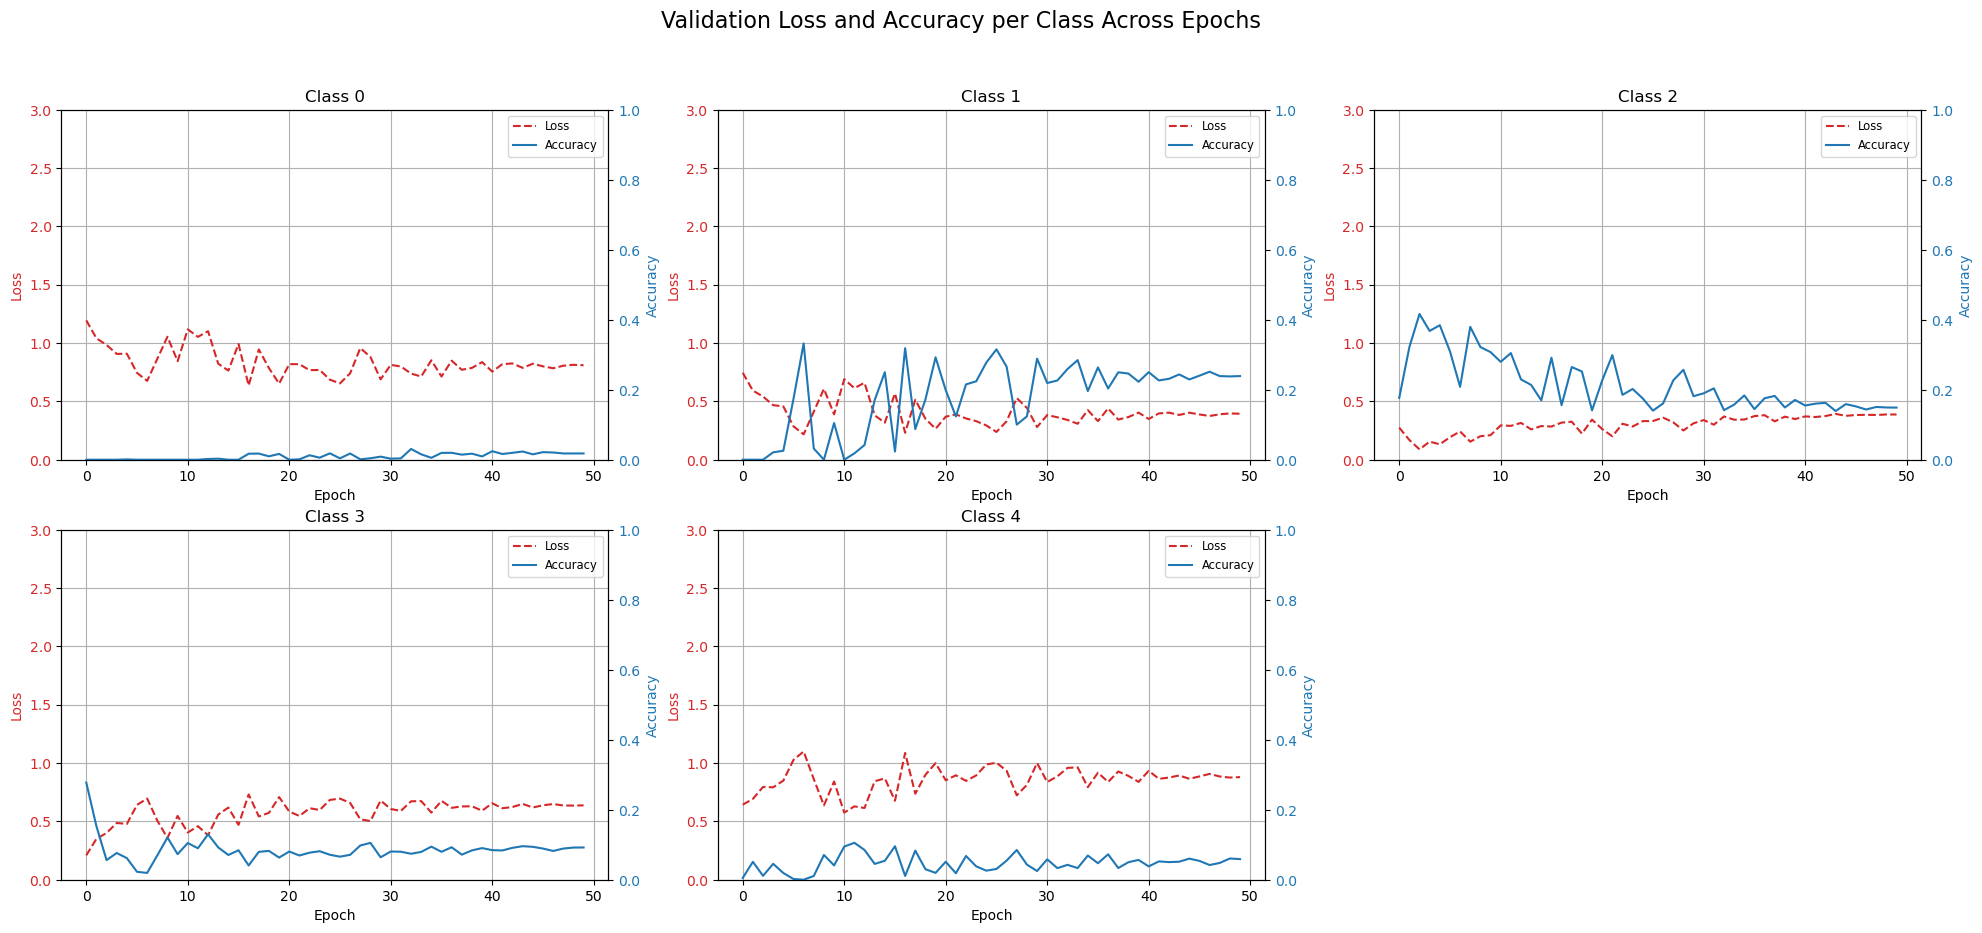

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming val_accuracy and val_loss are already stacked arrays of shape (n_epochs, n_classes)
val_accuracy = np.stack(data['results']['k0_cross_val_sub_0']['train_val']['list_val_accuracy_per_class'])
val_loss = np.stack(data['results']['k0_cross_val_sub_0']['train_val']['val_loss_per_class'])

n_epochs, n_classes = val_accuracy.shape

# Set up the subplot grid
n_cols = 3
n_rows = int(np.ceil(n_classes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 5))
axes = axes.flatten()

for class_idx in range(n_classes):
    ax1 = axes[class_idx]  # Main axis for loss
    ax2 = ax1.twinx()      # Twin axis for accuracy

    # Plot loss
    line1, = ax1.plot(val_loss[:, class_idx], color='tab:red', linestyle='--', label='Loss')
    ax1.set_ylim(0, 3)
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Plot accuracy
    line2, = ax2.plot(val_accuracy[:, class_idx], color='tab:blue', label='Accuracy')
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Combine legends (top right position)
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right', fontsize='small')

    ax1.set_title(f'Class {class_idx}')
    ax1.set_xlabel('Epoch')
    ax1.grid(True)

# Hide any unused subplots
for i in range(n_classes, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Validation Loss and Accuracy per Class Across Epochs', fontsize=16)
# fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



In [15]:
seq_len // t.shape[1]

256

In [18]:
import torch
t = torch.arange(1*72*1408).reshape(1,72,1408)
seq_len = 18432
repeat = torch.repeat_interleave(t, seq_len / t.shape[1], dim=1)
print(t)
repeat[:,0:257]

TypeError: repeat_interleave() received an invalid combination of arguments - got (Tensor, float, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)


In [ ]:
dict_args = {
    'loss': ['ce'],
    'num_classes': 5,
    'pos_enc': True,
    'dropout': 0.1,
    'attn_dropout': 0.1,
    'residual_dropout': 0.1,
    'embed_dim': 768,
    'num_heads': 8,
    'mlp_ratio': 1,
    'depth': 3,
    'cross_block_after_transformers': False
}
if dict_args['loss'] in 'ce':
    raise ValueError(f"Loss {dict_args['loss']} not supported. Supported losses: ce")

In [22]:
import pickle

pkl_path = "/media/villi/TOSHIBA EXT/test_video/test_Jun_20/history_run_whole_feats_L1_1236428_ATTENTIVE_JEPA_dune.micc_1750364470/1750364472283_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)

/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:483: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/ho

In [23]:
list(data.keys())

['results', 'time', 'config']

In [25]:
data['results']['k0_cross_val_sub_0']['train_val']['val_loss_per_subject']

array([[33.397575, 29.596565, 24.716492, ..., 31.60053 , 27.544832,
        24.620192],
       [30.947998, 29.992598, 25.43699 , ..., 32.157673, 29.176895,
        26.795126],
       [31.603165, 31.44439 , 26.998882, ..., 33.499306, 25.48996 ,
        25.417328],
       ...,
       [32.308964, 39.96868 , 31.443089, ..., 35.6736  , 32.94776 ,
        30.272575],
       [32.239227, 39.900513, 31.409845, ..., 35.73194 , 33.054035,
        30.305347],
       [32.22047 , 39.90497 , 31.417755, ..., 35.72494 , 32.99714 ,
        30.26477 ]], dtype=float32)

In [111]:
import torch
import numpy as np
import pytest
from torch import nn

def compute_loss_per_class_(criterion,
                             unique_train_val_classes,
                             batch_y,
                             outputs,
                             class_loss=None,
                             class_accuracy=None):
    if batch_y.dim() != 1:
        batch_y = torch.argmax(batch_y, 1)
    for cls in unique_train_val_classes:
        mask = (batch_y == cls).reshape(-1)
        if mask.any():
            class_idx = np.where(unique_train_val_classes == cls)[0][0]
            if class_accuracy is not None:
                if isinstance(criterion, nn.L1Loss) or isinstance(criterion, nn.MSELoss):
                    predicted = torch.copysign(torch.floor(torch.abs(outputs[mask]) + 0.5), outputs[mask])
                else:
                    predicted = torch.argmax(outputs[mask], 1 if outputs.dim() == 2 else 0)
                correct = (predicted == batch_y[mask]).sum().item()
                total = mask.sum().item()
                class_accuracy[class_idx] += correct / total
            if class_loss is not None:
                loss = criterion(outputs[mask], batch_y[mask]).detach().cpu().item()
                class_loss[class_idx] += loss


def test_classification_cross_entropy():
    criterion = nn.CrossEntropyLoss()
    unique_classes = np.array([0, 1])
    batch_y = torch.tensor([0, 1, 0, 1])
    outputs = torch.tensor([[2.0, 0.1], [0.2, 1.5], [1.9, 0.2], [0.3, 1.8]])
    class_loss = [0.0, 0.0]
    class_accuracy = [0.0, 0.0]

    compute_loss_per_class_(criterion, unique_classes, batch_y, outputs, class_loss, class_accuracy)

    assert class_accuracy[0] == pytest.approx(1.0)
    assert class_accuracy[1] == pytest.approx(1.0)
    assert class_loss[0] > 0
    assert class_loss[1] > 0


def test_regression_mse():
    criterion = nn.MSELoss()
    unique_classes = np.array([0, 1])
    batch_y = torch.tensor([0.0, 1.0, 0.0, 1.0])
    outputs = torch.tensor([0.2, 0.9, 0.1, 1.1])
    class_loss = [0.0, 0.0]
    class_accuracy = [0.0, 0.0]

    compute_loss_per_class_(criterion, unique_classes, batch_y, outputs, class_loss, class_accuracy)

    assert class_accuracy[0] == pytest.approx(1.0)
    assert class_accuracy[1] == pytest.approx(1.0)
    assert class_loss[0] > 0
    assert class_loss[1] > 0


def test_one_hot_labels():
    criterion = nn.CrossEntropyLoss()
    unique_classes = np.array([0, 1])
    batch_y = torch.tensor([[1, 0], [0, 1], [1, 0], [0, 1]])
    outputs = torch.tensor([[2.0, 0.1], [0.2, 1.5], [1.9, 0.2], [0.3, 1.8]])
    class_loss = [0.0, 0.0]
    class_accuracy = [0.0, 0.0]

    compute_loss_per_class_(criterion, unique_classes, batch_y, outputs, class_loss, class_accuracy)

    assert class_accuracy[0] == pytest.approx(1.0)
    assert class_accuracy[1] == pytest.approx(1.0)


def test_missing_class_in_batch():
    criterion = nn.CrossEntropyLoss()
    unique_classes = np.array([0, 1, 2])
    batch_y = torch.tensor([0, 0, 1, 1])
    outputs = torch.tensor([[2.0, 0.1, 0.0], [2.2, 0.0, 0.1],
                            [0.1, 1.9, 0.0], [0.2, 1.7, 0.1]])
    class_loss = [0.0, 0.0, 0.0]
    class_accuracy = [0.0, 0.0, 0.0]

    compute_loss_per_class_(criterion, unique_classes, batch_y, outputs, class_loss, class_accuracy)

    assert class_accuracy[2] == 0.0
    assert class_loss[2] == 0.0


test_classification_cross_entropy()
test_regression_mse()
test_one_hot_labels()
test_missing_class_in_batch()

In [42]:
import torch
import numpy as np
from torch.nn import CrossEntropyLoss, MSELoss, L1Loss

# === your function under test ===
def compute_loss_per_class_(criterion,
                            unique_train_val_classes,
                            batch_y,
                            outputs,
                            class_loss=None,
                            class_accuracy=None):
    if batch_y.dim() != 1:
        batch_y = torch.argmax(batch_y, 1)
    for cls in unique_train_val_classes:
        mask = (batch_y == cls).reshape(-1)
        if mask.any():
            class_idx = np.where(unique_train_val_classes == cls)[0][0]
            if class_accuracy is not None:
                if isinstance(criterion, (L1Loss, MSELoss)):
                    predicted = torch.copysign(
                        torch.floor(torch.abs(outputs[mask]) + 0.5),
                        outputs[mask]
                    )
                else:
                    if outputs.dim() == 2:
                        predicted = torch.argmax(outputs[mask], 1)
                    else:
                        predicted = torch.argmax(outputs[mask], 0)
                correct = (predicted == batch_y[mask]).sum().item()
                total = mask.sum().item()
                class_accuracy[class_idx] += correct / total
            if class_loss is not None:
                loss = criterion(outputs[mask], batch_y[mask]).detach().cpu().item()
                class_loss[class_idx] += loss

# === Helper for running one test case ===
def run_test(name, unique_classes, batch_y, outputs, criterion, 
             expected_acc, atol=1e-6):
    n = len(unique_classes)
    acc = np.zeros(n, dtype=float)
    compute_loss_per_class_(criterion,
                            unique_classes,
                            batch_y,
                            outputs,
                            class_accuracy=acc)
    print(f"{name}: computed acc = {acc}, expected = {expected_acc}")
    assert np.allclose(acc, expected_acc, atol=atol), \
        f"{name} failed: got {acc}, expected {expected_acc}"

# --- 1) Classification: all correct ---
unique = np.array([0,1,2])
batch_y1 = torch.tensor([0, 1, 2])
outputs1 = torch.tensor([[10,0,0],
                         [0,10,0],
                         [0,0,10]], dtype=torch.float)
expected1 = np.array([1.0, 1.0, 1.0])
run_test("all‐correct classification",
         unique, batch_y1, outputs1,
         CrossEntropyLoss(reduction='mean'),
         expected1)

# --- 2) Classification: half correct in class 1 only ---
unique = np.array([1])
batch_y2 = torch.tensor([1, 1])
outputs2 = torch.tensor([[0,10,0],
                         [10,0,0]], dtype=torch.float)
# class 1 has 2 samples, 1 correct (first), so accuracy = 0.5
expected2 = np.array([0.5])
run_test("half‐correct classification",
         unique, batch_y2, outputs2,
         CrossEntropyLoss(reduction='mean'),
         expected2)

# --- 3) Regression rounding behavior ---
unique = np.array([0,2])
batch_y3 = torch.tensor([0, 2], dtype=torch.float)
outputs3 = torch.tensor([0.4, 1.6], dtype=torch.float)
# 0.4 → round to 0 (correct), 1.6 → round to 2 (correct)
expected3 = np.array([1.0, 1.0])
run_test("regression rounding",
         unique, batch_y3, outputs3,
         MSELoss(reduction='mean'),
         expected3)

print("✅ All tests passed!")


all‐correct classification: computed acc = [1. 1. 1.], expected = [1. 1. 1.]
half‐correct classification: computed acc = [0.5], expected = [0.5]
regression rounding: computed acc = [1. 1.], expected = [1. 1.]
✅ All tests passed!


In [43]:
# --- 4) L1Loss: general rounding behavior with multiple samples ---
unique = np.array([0,1,2])
batch_y4 = torch.tensor([0, 1, 1, 2], dtype=torch.float)
# Predictions chosen so that:
# 0.49 → round to 0   (correct for class 0)
# 1.49 → round to 1   (correct for class 1, sample #1)
# 1.51 → round to 2   (incorrect for class 1, sample #2)
# 2.49 → round to 2   (correct for class 2)
outputs4 = torch.tensor([0.49, 1.49, 1.51, 2.49], dtype=torch.float)
# Expected accuracies: class0=1/1=1.0, class1=1/2=0.5, class2=1/1=1.0
expected4 = np.array([1.0, 0.5, 1.0])
run_test("L1 general rounding", 
         unique, batch_y4, outputs4, 
         L1Loss(reduction='mean'), 
         expected4)

# --- 5) L1Loss: exact .5‐boundary rounding ---
unique = np.array([0,1])
batch_y5 = torch.tensor([0, 1], dtype=torch.float)
# Exactly .5 inputs:
# 0.50 → abs+0.5=1.0 → floor=1, copysign=+1  (incorrect for class 0)
# 1.50 → abs+0.5=2.0 → floor=2, copysign=+2  (incorrect for class 1)
outputs5 = torch.tensor([0.50, 1.50], dtype=torch.float)
# Both should round *away* from zero on the .5 boundary, so both become wrong
expected5 = np.array([0.0, 0.0])
run_test("L1 .5‐boundary rounding", 
         unique, batch_y5, outputs5, 
         L1Loss(reduction='mean'), 
         expected5)

print("✅ All L1Loss accuracy tests passed!")


L1 general rounding: computed acc = [1.  0.5 1. ], expected = [1.  0.5 1. ]
L1 .5‐boundary rounding: computed acc = [0. 0.], expected = [0. 0.]
✅ All L1Loss accuracy tests passed!


In [ ]:
data['results']['k0_cross_val_sub_0']['train_val']['val_loss_per_class']

In [2]:
import torch  
acc_per_class = torch.tensor([  8.,  89., 817., 212.,  18.])
acc_per_class = acc_per_class / acc_per_class.sum()
acc_per_class

tensor([0.0070, 0.0778, 0.7142, 0.1853, 0.0157])

In [ ]:
import numpy as np
import pandas as pd

cross_attention_debug = data['cross_attention_debug']
test_batch = len(cross_attention_debug['debug_xattn_test'])
test_list_sample_id = []
test_xattn = []
for batch_sample_id,batch_xattn in cross_attention_debug['debug_xattn_test']:
  test_list_sample_id.append(batch_sample_id)
  test_xattn.append(batch_xattn)
  
test_list_sample_id = np.concatenate(test_list_sample_id,axis=0)
test_xattn = np.concatenate(test_xattn,axis=0)
test_history_predictions = data['results']['k0_cross_val_sub_0']['test']['history_test_sample_predictions']
csv_path = os.path.join(*data['config']['path_csv_dataset'])
df = pd.read_csv(csv_path,sep='\t')
print(test_list_sample_id.shape)
print(test_xattn.shape) # (n_sample, n_heads, nr_blocks, seq_len)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_map(list_sample_id,xattn, head_id, sample_id, df,prediction):
  gt = df[df['sample_id'] == sample_id]['class_id'].values[0]
  mask_video_id = (list_sample_id == sample_id)
  if mask_video_id.sum() == 0:
    print(f"Sample id {sample_id} not found in xattn")
    return None
  cross_attention = xattn[mask_video_id].squeeze(0) # [sample_id=1, num_heads, CLS, nr_sliding_windows]
  if head_id > cross_attention.shape[0]:
    print(f"Head id {head_id} not found in xattn")
    return None
  # xattn_vecs = cross_attention.squeeze(1)
  for idx_cls_head in range(cross_attention.shape[1]): 
    sns.heatmap(cross_attention[head_id][idx_cls_head][None, :], cmap='viridis', cbar=True,vmin=0)
    plt.xlabel("Sliding window index")
    plt.title(f"xattn from - CLS {idx_cls_head} - Head {head_id} - sample_id {sample_id} - (gt, pred): ({gt}, {prediction})")
    plt.show()

def plot_mean_attention_map(list_sample_id,xattn, head_id, sample_id, df,prediction):
  gt = df[df['sample_id'] == sample_id]['class_id'].values[0]
  mask_video_id = (list_sample_id == sample_id)
  if mask_video_id.sum() == 0:
    print(f"Sample id {sample_id} not found in xattn")
    return None
  cross_attention = xattn[mask_video_id].squeeze(0) # [sample_id=1, num_heads, CLS, nr_sliding_windows]
  if head_id > cross_attention.shape[0]:
    print(f"Head id {head_id} not found in xattn")
    return None 
  cross_attention_mean = cross_attention.mean(axis=0)  # Average across all heads
  sns.heatmap(cross_attention_mean, cmap='viridis', cbar=True,vmin=0)
  plt.xlabel("Sliding window index")
  plt.title(f"MEAN xattn - Head {head_id} - sample_id {sample_id} - (gt, pred): ({gt}, {prediction})")
  plt.show()

list_sample_id = list(test_history_predictions.keys())
for sample_id in list_sample_id:
# sample_id = list_sample_id[0]  # Choose a sample id from the list
  plot_mean_attention_map(list_sample_id=test_list_sample_id,
                          xattn=test_xattn,
                          head_id=0,
                          df=df,
                          sample_id=sample_id,
                          prediction=test_history_predictions[sample_id].item())
# for head_id in range(test_xattn.shape[1]):
#   plot_attention_map(list_sample_id=test_list_sample_id,
#                     xattn=test_xattn,
#                     head_id=head_id,
#                     df=df,
#                     sample_id=sample_id,
#                     prediction=test_history_predictions[sample_id].item())

In [ ]:
import os
import shutil

def link_all_pngs(root_folder, link_folder_name="linked_pngs"):
    # Create the destination folder
    link_folder = os.path.join(root_folder, link_folder_name)
    os.makedirs(link_folder, exist_ok=True)

    # Walk through the root directory and its subdirectories
    count = 0
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith(".png"):
                src_path = os.path.join(dirpath, filename)
                # Create a unique name in the link folder to avoid collisions
                rel_path = os.path.relpath(src_path, root_folder)
                safe_name = rel_path.replace(os.sep, "__")
                dest_path = os.path.join(link_folder, safe_name)

                try:
                    os.symlink(src_path, dest_path)
                    count += 1
                except FileExistsError:
                    print(f"Link already exists: {dest_path}")
                except OSError:
                    # On Windows without admin privileges, use copy instead of symlink
                    shutil.copy2(src_path, dest_path)
                    count += 1

    print(f"{count} PNG files linked/copied to: {link_folder}")

# Example usage:
link_all_pngs("/media/villi/TOSHIBA EXT/test_video/test_May_30_tsne/tsne_feats/whole_frontalized_giant_mirror_interpolation")


# MISS PREDICTIONS

In [ ]:
import pandas as pd
import pickle
import os
import custom.tools as tools

pkl_path = "/media/villi/TOSHIBA EXT/test_video/test_May_23/NP_vs_PA4/finetuned_1_1_1_stride4_ce/history_run_samples_0_4_finetuned_ce_1_1_1_stride4_2489476_ATTENTIVE_JEPA_harlock_1747827509/1747827511889_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
key = "k0_cross_val_sub_0"
df_csv_path = os.path.dirname(pkl_path)
csv_file = [f for f in os.listdir(df_csv_path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(df_csv_path,csv_file),sep='\t')
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)
best_epoch = data['results'][key]['train_val']['best_model_idx']
num_epochs = len(data['results'][key]['train_val']['train_losses'])
train_history_pred = data['results'][key]['train_val']['history_train_sample_predictions']
val_history_pred = data['results'][key]['train_val']['history_val_sample_predictions']
top_k = 20
miss_predictions_train_label,miss_predictions_train_sbj = tools.count_mispredictions(train_history_pred,df,top_k=top_k,return_miss_per_subject=True)
miss_predictions_val_label,miss_predictions_val_sbj = tools.count_mispredictions(val_history_pred,df,top_k=top_k,return_miss_per_subject=True)
miss_predictions_train_sbj_best_epoch = {k:v[best_epoch] for k,v in train_history_pred.items()}
miss_predictions_val_sbj_best_epoch = {k:v[best_epoch] for k,v in val_history_pred.items()}
test_history_pred = data['results'][key]['test']['history_test_sample_predictions']
_,miss_predictions_train_sbj_best = tools.count_mispredictions(miss_predictions_train_sbj_best_epoch,df,top_k=top_k,return_miss_per_subject=True)
_,miss_predictions_val_sbj_best = tools.count_mispredictions(miss_predictions_val_sbj_best_epoch,df,top_k=top_k,return_miss_per_subject=True)
_,miss_predictions_test_sbj_best = tools.count_mispredictions(test_history_pred,df,top_k=top_k,return_miss_per_subject=True)


In [ ]:
history_pred = miss_predictions_train_sbj_best_epoch
miss_prediction_sbj_sample_value = {}
for sample_id,pred_history in history_pred.items():
  # Get the ground truth class ID for the sample ID and count the number of mispredictions
  gt = df[df['sample_id'] == sample_id]['class_id'].values[0]
  sbj = df[df['sample_id'] == sample_id]['subject_id'].values[0]
  if pred_history != gt:
    if sbj not in miss_prediction_sbj_sample_value:
      miss_prediction_sbj_sample_value[sbj] = {}
    miss_prediction_sbj_sample_value[sbj][sample_id] = {'gt': gt, 'pred': pred_history.item(),'name':df[df['sample_id'] == sample_id]['sample_name'].values[0]}

In [ ]:
miss_prediction_sbj_sample_value[76]

# TEST Accuracy

In [ ]:
import torch
import numpy as np
import custom.tools as tools 
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
)


# Test case 1: Simple multi-class classification
true_labels_1 = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
predicted_labels_1 = np.array([0, 1, 2, 0, 2, 1, 0, 1, 2])
num_classes_1 = 3
cm_torch_1 = torch.tensor(confusion_matrix(true_labels_1, predicted_labels_1))
results_1 = tools.evaluate_classification_from_confusion_matrix(cm_torch_1)

print("Test Case 1:")
print("Confusion Matrix:\n", cm_torch_1)

sklearn_precision_1 = precision_score(true_labels_1, predicted_labels_1, average=None)
sklearn_recall_1 = recall_score(true_labels_1, predicted_labels_1, average=None)
sklearn_accuracy_1 = accuracy_score(true_labels_1, predicted_labels_1)
sklearn_macro_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='macro')
sklearn_macro_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='macro')
sklearn_micro_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='micro')
sklearn_micro_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='micro')
sklearn_weighted_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='weighted')
sklearn_weighted_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='weighted')

print("Your Results:")
for key, value in results_1.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_1}")
print(f"recall_per_class: {sklearn_recall_1}")
print(f"macro_precision: {sklearn_macro_precision_1}")
print(f"macro_recall: {sklearn_macro_recall_1}")
print(f"micro_precision: {sklearn_micro_precision_1}")
print(f"micro_recall: {sklearn_micro_recall_1}")
print(f"weighted_precision: {sklearn_weighted_precision_1}")
print(f"weighted_recall: {sklearn_weighted_recall_1}")
print(f"accuracy: {sklearn_accuracy_1}")

# Comparison for Test Case 1
print("\nComparison with Scikit-learn (Test Case 1):")
np.testing.assert_allclose(results_1['precision_per_class'], sklearn_precision_1, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_1['recall_per_class'], sklearn_recall_1, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_1['macro_precision'], sklearn_macro_precision_1, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_1['macro_recall'], sklearn_macro_recall_1, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_1['micro_precision'], sklearn_micro_precision_1, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_1['micro_recall'], sklearn_micro_recall_1, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_1['weighted_precision'], sklearn_weighted_precision_1, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_1['weighted_recall'], sklearn_weighted_recall_1, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_1['accuracy'], sklearn_accuracy_1, err_msg="Accuracy mismatch")
print("All values in Test Case 1 match scikit-learn.")

print("-" * 50)

# Test case 2: Binary classification
true_labels_2 = np.array([0, 0, 1, 1, 1])
predicted_labels_2 = np.array([0, 1, 1, 0, 1])
num_classes_2 = 2
cm_torch_2 = torch.tensor(confusion_matrix(true_labels_2, predicted_labels_2))
results_2 = tools.evaluate_classification_from_confusion_matrix(cm_torch_2)

print("\nTest Case 2 (Binary Classification):")
print("Confusion Matrix:\n", cm_torch_2)

sklearn_precision_2 = precision_score(true_labels_2, predicted_labels_2, average=None)
sklearn_recall_2 = recall_score(true_labels_2, predicted_labels_2, average=None)
sklearn_accuracy_2 = accuracy_score(true_labels_2, predicted_labels_2)
sklearn_macro_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='macro')
sklearn_macro_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='macro')
sklearn_micro_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='micro')
sklearn_micro_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='micro')
sklearn_weighted_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='weighted')
sklearn_weighted_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='weighted')

print("Your Results:")
for key, value in results_2.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_2}")
print(f"recall_per_class: {sklearn_recall_2}")
print(f"macro_precision: {sklearn_macro_precision_2}")
print(f"macro_recall: {sklearn_macro_recall_2}")
print(f"micro_precision: {sklearn_micro_precision_2}")
print(f"micro_recall: {sklearn_micro_recall_2}")
print(f"weighted_precision: {sklearn_weighted_precision_2}")
print(f"weighted_recall: {sklearn_weighted_recall_2}")
print(f"accuracy: {sklearn_accuracy_2}")

# Comparison for Test Case 2
print("\nComparison with Scikit-learn (Test Case 2):")
np.testing.assert_allclose(results_2['precision_per_class'], sklearn_precision_2, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_2['recall_per_class'], sklearn_recall_2, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_2['macro_precision'], sklearn_macro_precision_2, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_2['macro_recall'], sklearn_macro_recall_2, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_2['micro_precision'], sklearn_micro_precision_2, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_2['micro_recall'], sklearn_micro_recall_2, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_2['weighted_precision'], sklearn_weighted_precision_2, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_2['weighted_recall'], sklearn_weighted_recall_2, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_2['accuracy'], sklearn_accuracy_2, err_msg="Accuracy mismatch")
print("All values in Test Case 2 match scikit-learn.")

print("-" * 50)

# Test case 3: Imbalanced dataset
true_labels_3 = np.array([0, 0, 0, 0, 1, 1])
predicted_labels_3 = np.array([0, 0, 1, 0, 1, 0])
num_classes_3 = 2
cm_torch_3 = torch.tensor(confusion_matrix(true_labels_3, predicted_labels_3))
results_3 = tools.evaluate_classification_from_confusion_matrix(cm_torch_3)

print("\nTest Case 3 (Imbalanced Dataset):")
print("Confusion Matrix:\n", cm_torch_3)

sklearn_precision_3 = precision_score(true_labels_3, predicted_labels_3, average=None)
sklearn_recall_3 = recall_score(true_labels_3, predicted_labels_3, average=None)
sklearn_accuracy_3 = accuracy_score(true_labels_3, predicted_labels_3)
sklearn_macro_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='macro')
sklearn_macro_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='macro')
sklearn_micro_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='micro')
sklearn_micro_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='micro')
sklearn_weighted_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='weighted')
sklearn_weighted_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='weighted')

print("Your Results:")
for key, value in results_3.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_3}")
print(f"recall_per_class: {sklearn_recall_3}")
print(f"macro_precision: {sklearn_macro_precision_3}")
print(f"macro_recall: {sklearn_macro_recall_3}")
print(f"micro_precision: {sklearn_micro_precision_3}")
print(f"micro_recall: {sklearn_micro_recall_3}")
print(f"weighted_precision: {sklearn_weighted_precision_3}")
print(f"weighted_recall: {sklearn_weighted_recall_3}")
print(f"accuracy: {sklearn_accuracy_3}")

# Comparison for Test Case 3
print("\nComparison with Scikit-learn (Test Case 3):")
np.testing.assert_allclose(results_3['precision_per_class'], sklearn_precision_3, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_3['recall_per_class'], sklearn_recall_3, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_3['macro_precision'], sklearn_macro_precision_3, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_3['macro_recall'], sklearn_macro_recall_3, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_3['micro_precision'], sklearn_micro_precision_3, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_3['micro_recall'], sklearn_micro_recall_3, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_3['weighted_precision'], sklearn_weighted_precision_3, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_3['weighted_recall'], sklearn_weighted_recall_3, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_3['accuracy'], sklearn_accuracy_3, err_msg="Accuracy mismatch")
print("All values in Test Case 3 match scikit-learn.")